In [22]:
import pandas as pd
import numpy as np


df = pd.read_csv("dataset.csv")


df = df.drop("Unnamed: 0", axis=1) # drop index
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,no,2.2,0,1,no,7,0.6,188,2,...,20,756,2549.0,9,7,19.0,0,0,wifi,medium cost
1,1021,yes,0.5,1,0,yes,53,0.7,136,3,...,905,1988,2631.0,17,3,7.0,1,1,no_wifi,high cost
2,563,yes,0.5,1,2,yes,41,0.9,145,5,...,1263,1716,2603.0,11,2,9.0,1,1,no_wifi,high cost
3,615,yes,2.5,0,0,no,10,0.8,131,6,...,1216,1786,2769.0,16,8,11.0,1,0,no_wifi,high cost
4,1821,yes,1.2,0,13,yes,44,0.6,141,2,...,1208,1212,1411.0,8,2,15.0,1,1,no_wifi,medium cost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,794,yes,0.5,1,0,yes,2,0.8,106,6,...,1222,1890,668.0,13,4,19.0,1,1,no_wifi,low cost
1931,1965,yes,2.6,1,0,no,39,0.2,187,4,...,915,1965,2032.0,11,10,16.0,1,1,wifi,high cost
1932,1911,no,0.9,1,1,yes,36,0.7,108,8,...,868,1632,3057.0,9,1,5.0,1,1,no_wifi,very high cost
1933,1512,no,0.9,0,4,yes,46,0.1,145,5,...,336,670,869.0,18,10,19.0,1,1,wifi,low cost


In [23]:
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

categories = ["very high cost", "high cost", "medium cost", "low cost"]
label_cols = ["price_range"]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_string_cols = (df.select_dtypes(include=['object', 'string']).drop("price_range",axis=1)).columns.tolist()

X = df.drop(columns=label_cols, axis=1)
y = df[label_cols]

print(label_cols)
print(numeric_cols)
print(feature_string_cols)

label_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(categories=categories, sparse_output=False))
])

text_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(sparse_output=False))
])

number_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])


ct = ColumnTransformer([
    ("txt", text_pipeline, feature_string_cols),
    ("nmb", number_pipeline, numeric_cols),
], remainder='passthrough')


X_transformed = ct.fit_transform(X)
X_df = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out())

le = LabelEncoder()
y_encoded = le.fit_transform(y)  

X_df.info()

['price_range']
['battery_power', 'clock_speed', 'dual_sim', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen']
['blue', 'four_g', 'wifi']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   txt__blue_no        1935 non-null   float64
 1   txt__blue_yes       1935 non-null   float64
 2   txt__four_g_no      1935 non-null   float64
 3   txt__four_g_yes     1935 non-null   float64
 4   txt__wifi_no_wifi   1935 non-null   float64
 5   txt__wifi_wifi      1935 non-null   float64
 6   nmb__battery_power  1935 non-null   float64
 7   nmb__clock_speed    1935 non-null   float64
 8   nmb__dual_sim       1935 non-null   float64
 9   nmb__fc             1935 non-null   float64
 10  nmb__int_memory     1935 non-null   float64
 11  nmb__m_dep      

/home/cubeq/Projects/Informatyka/PricePrediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:120: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_to_split, y_train, y_to_split = train_test_split(X_df, y_encoded, test_size=0.66, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_to_split, y_to_split, test_size=0.5, random_state=42)

In [25]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

input_count = len(X_df.columns)
output_count = len(y_encoded)

keras.utils.set_random_seed(42)

model = keras.Sequential([
    keras.layers.Input((input_count,)),  # If we write (n_input_features), it will simplify to int. If add a comma, it will be a single-element tuple
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(4, activation="softmax")
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 100)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,004 (89.86 KB)

 Trainable params: 23,004 (89.86 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
initial_weights = model.get_weights()
optimizer = keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.set_weights(initial_weights)


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.1, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    epochs=100,
    verbose=1,
    validation_data=(X_train, y_train),
    callbacks=[early_stopping, reduce_lr]
) 

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3181 - loss: 2.8046 - val_accuracy: 0.5084 - val_loss: 1.0668
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5419 - loss: 1.0814 - val_accuracy: 0.5814 - val_loss: 0.8903
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5510 - loss: 0.9880 - val_accuracy: 0.5297 - val_loss: 0.8836
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6758 - loss: 0.6961 - val_accuracy: 0.7671 - val_loss: 0.5864
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7336 - loss: 0.5854 - val_accuracy: 0.7580 - val_loss: 0.5791
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7869 - loss: 0.6008 - val_accuracy: 0.7062 - val_loss: 0.9180
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7260 - loss: 0.7464 - val_accuracy: 0.6240 - val_loss: 0.7464
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7671 - loss: 0.5662 - val_accuracy: 0.8037 - v

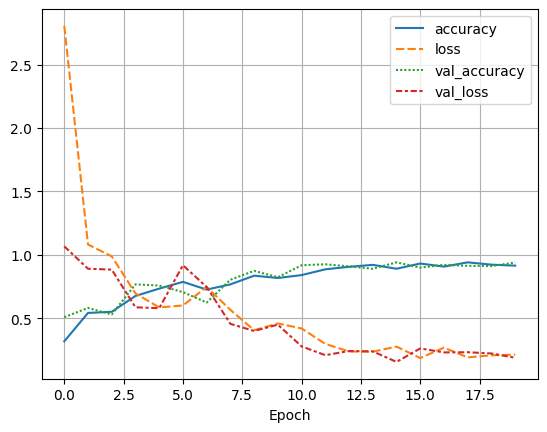

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_history(history):
    sns.lineplot(history.history)
    plt.grid()
    plt.xlabel("Epoch")

display_history(history)

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report

def predict(X, y):
    probabilities = model.predict(X)
    predicted_classes = np.argmax(probabilities, axis=1)

    print("\nFull Classification Report:")
    print(classification_report(y_test, predicted_classes, target_names=['very high', 'high', 'medium', 'low']))



predict(X_test, y_test)
predict(X_validate, y_validate)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Full Classification Report:
              precision    recall  f1-score   support

   very high       0.79      0.90      0.84       167
        high       0.88      0.90      0.89       159
      medium       0.82      0.70      0.75       149
         low       0.94      0.92      0.93       164

    accuracy                           0.86       639
   macro avg       0.86      0.85      0.85       639
weighted avg       0.86      0.86      0.86       639

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step

Full Classification Report:
              precision    recall  f1-score   support

   very high       0.25      0.26      0.25       167
        high       0.25      0.25      0.25       159
      medium       0.25      0.23      0.24       149
         low       0.23      0.25      0.24       164

    accuracy                           0.25       639
   macro avg       0.25      0.25      0.25       639
weighted avg       0.25      0.25      0.25   